In [40]:
!pip install gensim -U

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df = pd.read_csv('/content/sample_data/NikeProductDescriptions.csv')
print(df.shape)
print(df.columns)
print(df.head())

(400, 3)
Index(['Title', 'Subtitle', 'Product Description'], dtype='object')
                          Title     Subtitle  \
0          Nike Air Force 1 '07  Men's Shoes   
1          Nike Air Max Dawn SE  Men's Shoes   
2  Nike SB Dunk Low Pro Premium  Skate Shoes   
3   Nike Air Force 1 Mid '07 LX  Men's Shoes   
4      Nike Air Force 1 Mid '07  Men's Shoes   

                                 Product Description  
0  It doesn't get more legendary than this. Desig...  
1  Find out what moves you with the Air Max Dawn....  
2  Pack your style—on your feet. Bringing a fresh...  
3  The celebrations just keep coming. Unbox the A...  
4  Got your fave colour yet? No worries, the Colo...  


In [5]:
print(df['Subtitle'].value_counts())
print(df.isnull().sum())

Subtitle
Women's Shoes                                        34
Men's Shoes                                          31
Skate Shoes                                          22
Men's T-Shirt                                        14
Older Kids' T-Shirt                                   9
                                                     ..
Women's Logo Leggings                                 1
Women's High-Waisted Wide-Leg Terry Trousers          1
Women's Brief-Lined Running Shorts                    1
Women's Medium-Support Padded Longline Sports Bra     1
Women's High-Rise Leggings (Maternity)                1
Name: count, Length: 228, dtype: int64
Title                  0
Subtitle               0
Product Description    0
dtype: int64


In [6]:
subtitles_to_keep = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes", "Skate Shoes", "Older Kids' T-Shirt"
]

# Include all subtitles containing "Shorts"
df = df[df['Subtitle'].notna()]
df_filtered = df[df['Subtitle'].isin(subtitles_to_keep) | df['Subtitle'].str.contains("Shorts", case=False)]

# Rename all shorts categories to "Shorts"
df_filtered['Subtitle'] = df_filtered['Subtitle'].apply(lambda x: "Shorts" if 'shorts' in x.lower() else x)

print(df_filtered['Subtitle'].value_counts())

Subtitle
Shorts                 45
Women's Shoes          34
Men's Shoes            31
Skate Shoes            22
Men's T-Shirt          14
Older Kids' T-Shirt     9
Name: count, dtype: int64


In [7]:
print(df.columns)

Index(['Title', 'Subtitle', 'Product Description'], dtype='object')


In [8]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

# Apply preprocessing
df_filtered['tokens'] = df_filtered['Product Description'].astype(str).apply(preprocess_text)

In [9]:
#Bag of Words
bow_vectorizer = CountVectorizer(analyzer=lambda x: x)
bow = bow_vectorizer.fit_transform(df_filtered['tokens']).toarray()

#TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer=lambda x: x)
tfidf = tfidf_vectorizer.fit_transform(df_filtered['tokens']).toarray()

In [10]:
w2v_model = Word2Vec(sentences=df_filtered['tokens'], vector_size=100, window=5, min_count=1, workers=4)

def get_w2v_vector(tokens):
    vecs = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

w2v = np.array([get_w2v_vector(tokens) for tokens in df_filtered['tokens']])

In [14]:
def load_glove_model(path):
    glove_model = {}
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            glove_model[word] = vector
    return glove_model

glove_path = '/path/to/glove.6B.100d.txt'  # update path
glove = load_glove_model(glove_path)

def get_glove_vector(tokens):
    vecs = [glove[word] for word in tokens if word in glove]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

glove_vecs = np.array([get_glove_vector(tokens) for tokens in df_filtered['tokens']])

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/glove.6B.100d.txt'

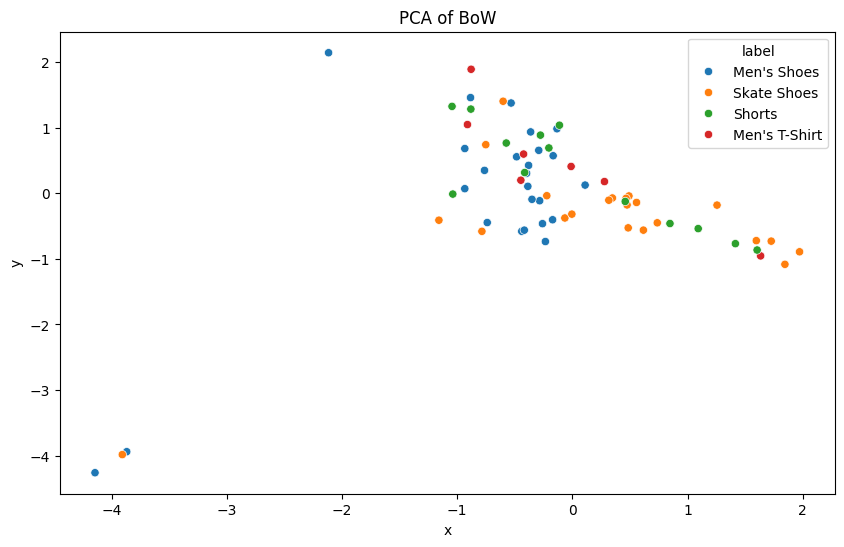

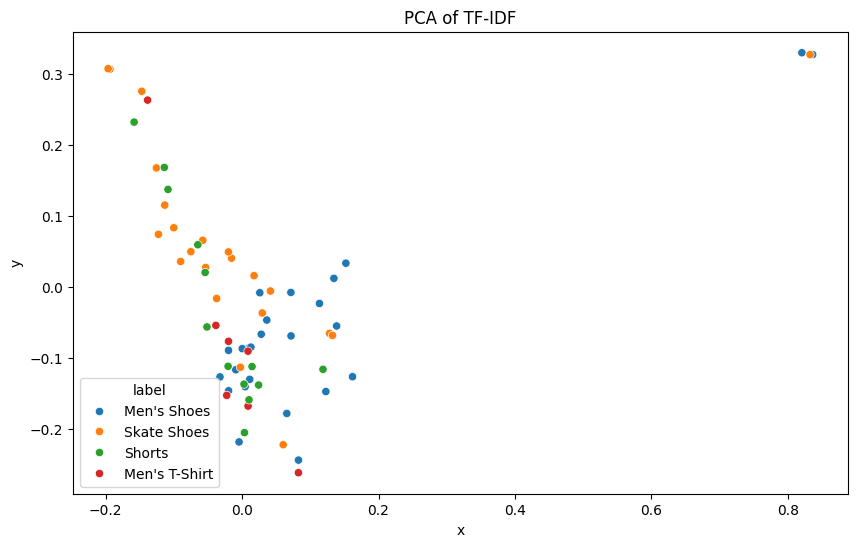

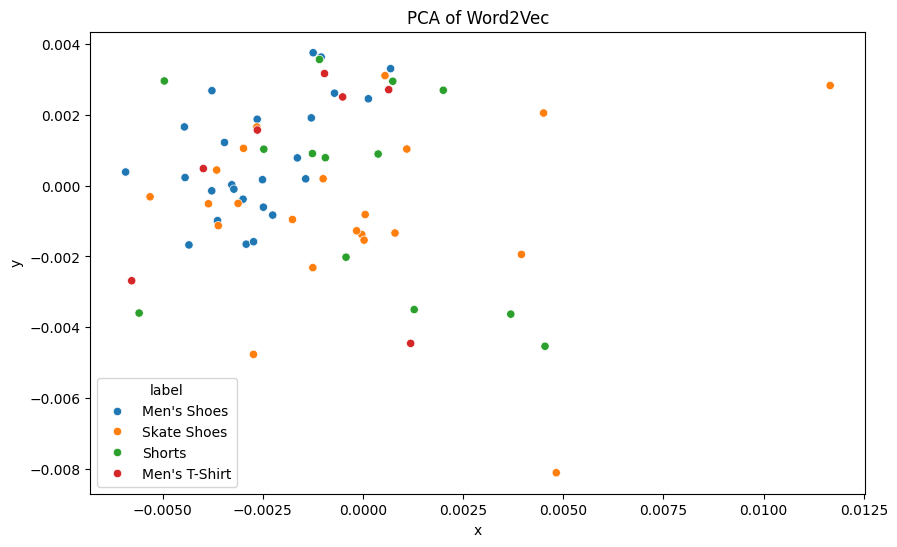

NameError: name 'glove_vecs' is not defined

In [16]:
def plot_pca(vectors, title, labels):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    df_plot = pd.DataFrame()
    df_plot['x'] = reduced[:, 0]
    df_plot['y'] = reduced[:, 1]
    df_plot['label'] = labels

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette='tab10')
    plt.title(f'PCA of {title}')
    plt.show()

# Label encoding subtitles
labels = df_filtered['Subtitle']
plot_pca(bow, "BoW", labels)
plot_pca(tfidf, "TF-IDF", labels)
plot_pca(w2v, "Word2Vec", labels)
plot_pca(glove_vecs, "GloVe", labels)